<a href="https://colab.research.google.com/github/Modinat-A/CE888/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation

In [ ]:
file="https://raw.githubusercontent.com/albanda/CE888/master/lab8/weather.csv"
df = pd.read_csv(file)

In [ ]:
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df

,date,radiation_avg,precip,wind_avg,wind_max,temp_avg,humidity_avg
0,14/05/2014 00:00,159,0.0,1.4,3.3,14.27,64.95
1,15/05/2014 00:00,280,0.0,0.6,2.3,13.51,72.91
2,16/05/2014 00:00,186,3.4,0.8,2.7,15.65,74.69
3,17/05/2014 00:00,221,0.0,1.0,3.3,17.46,71.42
4,18/05/2014 00:00,255,0.0,2.1,5.5,16.85,74.45
...,...,...,...,...,...,...,...
2551,17/05/2021 00:00,196,1.4,2.2,5.5,10.51,99.86
2552,17/05/2021 00:00,173,2.8,1.8,5.5,10.80,99.86
2553,18/05/2021 00:00,311,0.0,1.4,5.0,10.29,92.94
2554,19/05/2021 00:00,232,6.6,1.8,5.5,11.39,90.32


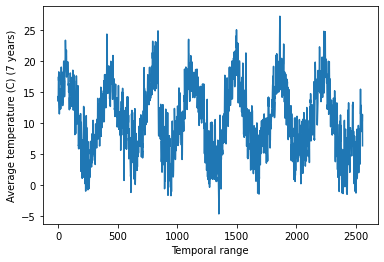

In [ ]:
plt.plot(range(len(df)), df['temp_avg'])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (7 years)')
plt.savefig('temperature_over_time.pdf', bbox_inches='tight')

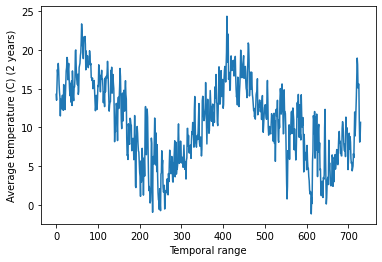

In [ ]:
# Look at the first 2 years
length = 2*365
plt.plot(range(length), df['temp_avg'][:length])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (2 years)')
plt.savefig('temperature_over_time_2y.pdf', bbox_inches='tight')

In [ ]:
n_tr, n_val = int(0.5*len(df)), int(0.3*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 1278; validation: 766; test: 512


In [ ]:
# Get the data from the dataframe (dropping date column)
data = df.iloc[:, 1:].values
print(data.shape)
assert data.shape[0] == len(df)
assert data.shape[1] == len(df.columns)-1, "Are you sure you're dropping the date?"

# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data = (data - mean_tr) / std_tr


y = df['temp_avg'].values.reshape(-1, 1)

# index of the column that contains the avg_temp
y_idx = 4

(2556, 6)


In [ ]:
data[:20, y_idx]  * std_tr[y_idx] + mean_tr[y_idx]

array([14.27, 13.51, 15.65, 17.46, 16.85, 18.26, 17.35, 15.55, 14.52,
       13.93, 11.48, 13.63, 12.81, 12.4 , 13.67, 14.15, 13.22, 12.21,
       15.53, 14.52])

In [ ]:
y[5:25]

array([[18.26],
       [17.35],
       [15.55],
       [14.52],
       [13.93],
       [11.48],
       [13.63],
       [12.81],
       [12.4 ],
       [13.67],
       [14.15],
       [13.22],
       [12.21],
       [15.53],
       [14.52],
       [15.35],
       [12.29],
       [13.88],
       [15.13],
       [17.29]])

In [ ]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 14  # 2 weeks to predict tomorrow's temperature
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 16

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  # first 50% for training
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  # 50%-80% for validation
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  # last 20% for test
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    #print(X[:, :, y_idx] * std_tr[y_idx] + mean_tr[y_idx])
    #print(target)
    break  # so we only print once

X shape: (16, 14, 6)
target shape: (16, 1)


In [ ]:
# Function to plot history with neural networks
def plot_hist_regression(hist, y):
  n_ = len(hist.history['mae'])
  plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set')
  plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("MAE (degrees)")
  plt.axhline(y=y)
  plt.show()

## Establishing a baseline

In [ ]:
def naive_method(dataset, mean, std):
    error = 0
    samples = 0
    count = 0
    for X, target in dataset:
        pred = X[:, -1, y_idx] * std + mean  # predict last available temperature and un-standardise
        #print(X.shape, target.shape, pred.shape)  # [batch_size, sequence_length, n_feats]
        #print(X[:, -1, y_idx] * std + mean, target)
        error += np.sum(np.abs(pred - target))
        samples += X.shape[0]  # batch_size
        count += 1
    return error / samples / batch_size # average


print('MAE on train set = %.2f (degrees Celsius)' % naive_method(train_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on validation set = %.2f (degrees Celsius)' % naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on test set = %.2f (degrees Celsius)' % naive_method(test_dataset, mean_tr[y_idx], std_tr[y_idx]))
# Save MAE on validation for later
baseline = naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx])

MAE on train set = 2.56 (degrees Celsius)
MAE on validation set = 2.69 (degrees Celsius)
MAE on test set = 2.85 (degrees Celsius)


In [ ]:
# To get some practice with neural networks, we'll try a 1-layer NN with nothing fancy.

model_dense = models.Sequential()
model_dense.add(layers.Flatten(input_shape=(sequence_length, len(df.columns)-1)))  # we need to specify the input shape or we won't be able to see the summary
model_dense.add(layers.Dense(10, activation='relu'))
model_dense.add(layers.Dense(1))

model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 10)                850       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 20

model_dense.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_dense = model_dense.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 2s 11ms/step - loss: 135.3578 - mae: 10.7551 - val_loss: 116.1266 - val_mae: 9.7935
Epoch 2/20
80/80 [==============================] - 1s 7ms/step - loss: 98.8001 - mae: 9.0985 - val_loss: 80.6110 - val_mae: 8.0712
Epoch 3/20
80/80 [==============================] - 1s 9ms/step - loss: 66.6964 - mae: 7.3163 - val_loss: 53.6344 - val_mae: 6.3578
Epoch 4/20
80/80 [==============================] - 1s 7ms/step - loss: 46.1210 - mae: 5.8523 - val_loss: 39.0521 - val_mae: 5.1430
Epoch 5/20
80/80 [==============================] - 1s 9ms/step - loss: 36.9793 - mae: 5.0801 - val_loss: 33.1527 - val_mae: 4.6670
Epoch 6/20
80/80 [==============================] - 1s 9ms/step - loss: 33.0644 - mae: 4.7580 - val_loss: 30.9519 - val_mae: 4.4929
Epoch 7/20
80/80 [==============================] - 1s 7ms/step - loss: 30.5441 - mae: 4.5587 - val_loss: 29.6293 - val_mae: 4.3848
Epoch 8/20
80/80 [==============================] - 1s 9ms/step - loss: 

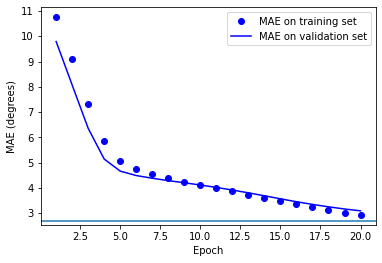

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_dense, baseline)

In [ ]:
# We know that CNNs take advantage of neighbouring values, so why don't we try that?

# In addition to the Conv2D layers we saw last week, there are Conv1D and Conv3D layers. 
# Conv1D layers rely on 1D windows that slide across an input sequence (imagine a 1D image)

model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(8, 7, activation='relu', input_shape=(sequence_length, len(df.columns)-1)))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.Conv1D(8, 3, activation='relu'))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.GlobalAveragePooling1D())
model_cnn.add(layers.Dense(1))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 8)              344       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 8)             0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 8)              200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 8)             0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                      

In [ ]:
model_cnn.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_cnn = model_cnn.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 2s 11ms/step - loss: 129.0558 - mae: 10.0513 - val_loss: 110.8153 - val_mae: 8.9310
Epoch 2/20
80/80 [==============================] - 1s 9ms/step - loss: 83.6872 - mae: 7.8988 - val_loss: 65.0987 - val_mae: 6.7465
Epoch 3/20
80/80 [==============================] - 1s 9ms/step - loss: 34.3769 - mae: 4.8972 - val_loss: 27.5944 - val_mae: 3.9777
Epoch 4/20
80/80 [==============================] - 1s 7ms/step - loss: 17.3937 - mae: 3.3198 - val_loss: 22.1514 - val_mae: 3.3090
Epoch 5/20
80/80 [==============================] - 1s 8ms/step - loss: 15.3525 - mae: 3.0906 - val_loss: 21.2424 - val_mae: 3.2044
Epoch 6/20
80/80 [==============================] - 1s 9ms/step - loss: 14.1973 - mae: 2.9847 - val_loss: 20.5388 - val_mae: 3.1426
Epoch 7/20
80/80 [==============================] - 1s 7ms/step - loss: 13.3091 - mae: 2.9029 - val_loss: 19.8556 - val_mae: 3.0977
Epoch 8/20
80/80 [==============================] - 1s 7ms/step - loss: 

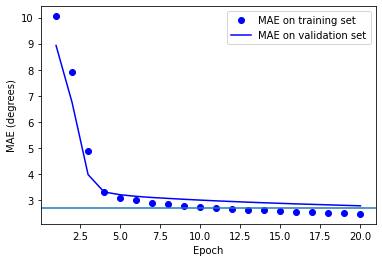

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_cnn, baseline)

## Long Short Term Memory (LSTM) Neural Networks

In [ ]:
# 1-layer LSTM

model_lstm1 = models.Sequential()
model_lstm1.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1)))
model_lstm1.add(layers.Dense(1))

model_lstm1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2160      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 20

In [ ]:
model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 4s 20ms/step - loss: 138.9194 - mae: 10.6168 - val_loss: 119.5106 - val_mae: 9.6367
Epoch 2/20
80/80 [==============================] - 1s 13ms/step - loss: 96.1382 - mae: 8.5667 - val_loss: 68.7913 - val_mae: 6.7824
Epoch 3/20
80/80 [==============================] - 2s 20ms/step - loss: 56.7449 - mae: 6.2580 - val_loss: 46.4770 - val_mae: 5.3639
Epoch 4/20
80/80 [==============================] - 1s 13ms/step - loss: 40.3545 - mae: 5.1999 - val_loss: 36.0629 - val_mae: 4.7318
Epoch 5/20
80/80 [==============================] - 1s 14ms/step - loss: 30.9321 - mae: 4.5101 - val_loss: 29.1956 - val_mae: 4.2747
Epoch 6/20
80/80 [==============================] - 1s 13ms/step - loss: 24.8179 - mae: 4.0359 - val_loss: 24.3165 - val_mae: 3.9187
Epoch 7/20
80/80 [==============================] - 1s 15ms/step - loss: 20.5401 - mae: 3.6737 - val_loss: 20.7145 - val_mae: 3.6231
Epoch 8/20
80/80 [==============================] - 1s 14ms/step -

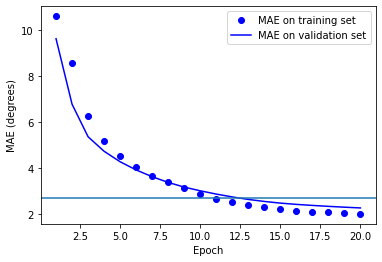

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm1, baseline)

In [ ]:
print('Test MAE = %.2f degrees' % model_lstm1.evaluate(test_dataset)[1])

31/31 [==============================] - 0s 5ms/step - loss: 9.1005 - mae: 2.4104
Test MAE = 2.41 degrees


In [ ]:
# Adding dropout

model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))
model_lstm2.add(layers.Dropout(0.4))
model_lstm2.add(layers.Dense(1))

model_lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2160      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 4s 23ms/step - loss: 133.4087 - mae: 10.5180 - val_loss: 108.1754 - val_mae: 9.3336
Epoch 2/20
80/80 [==============================] - 2s 20ms/step - loss: 86.5144 - mae: 8.2369 - val_loss: 58.2280 - val_mae: 6.3038
Epoch 3/20
80/80 [==============================] - 2s 19ms/step - loss: 49.4975 - mae: 5.8573 - val_loss: 38.6358 - val_mae: 4.8878
Epoch 4/20
80/80 [==============================] - 2s 19ms/step - loss: 37.0006 - mae: 4.9479 - val_loss: 30.5314 - val_mae: 4.3659
Epoch 5/20
80/80 [==============================] - 2s 19ms/step - loss: 29.1023 - mae: 4.3515 - val_loss: 25.2326 - val_mae: 3.9862
Epoch 6/20
80/80 [==============================] - 2s 19ms/step - loss: 24.9216 - mae: 3.9769 - val_loss: 21.1573 - val_mae: 3.6506
Epoch 7/20
80/80 [==============================] - 3s 34ms/step - loss: 22.3278 - mae: 3.7678 - val_loss: 18.3859 - val_mae: 3.4124
Epoch 8/20
80/80 [==============================] - 2s 20ms/step -

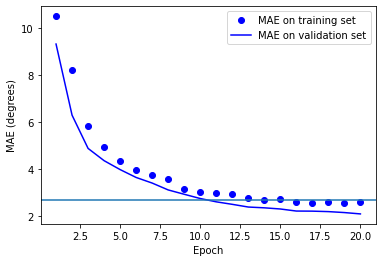

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm2, baseline)

In [ ]:
print('Test MAE = %.2f degrees' % model_lstm2.evaluate(test_dataset)[1])

31/31 [==============================] - 1s 9ms/step - loss: 7.4937 - mae: 2.1373
Test MAE = 2.14 degrees


In [ ]:
# Performance in the previous figure can (maybe) still be improved
# Let's try to add some more layers -- we can do this now that we're no longer overfitting

model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25, return_sequences=True))  # NEW!
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))  # NEW!!
model_lstm3.add(layers.Dropout(0.4))
model_lstm3.add(layers.Dense(1))
model_lstm3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 20)            2160      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,461
Trainable params: 5,461
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_mae', patience=2)]

history_lstm3 = model_lstm3.fit(train_dataset, epochs=60,  # increased number of epochs
                            validation_data=val_dataset,
                            callbacks=callbacks)  # but added early stopping callback

Epoch 1/60
80/80 [==============================] - 8s 37ms/step - loss: 114.4838 - mae: 9.5409 - val_loss: 66.7932 - val_mae: 6.8210
Epoch 2/60
80/80 [==============================] - 3s 31ms/step - loss: 53.4096 - mae: 6.0423 - val_loss: 40.9321 - val_mae: 5.0276
Epoch 3/60
80/80 [==============================] - 3s 31ms/step - loss: 38.3626 - mae: 5.0673 - val_loss: 33.2416 - val_mae: 4.5915
Epoch 4/60
80/80 [==============================] - 3s 38ms/step - loss: 30.9709 - mae: 4.5456 - val_loss: 27.2261 - val_mae: 4.1475
Epoch 5/60
80/80 [==============================] - 3s 41ms/step - loss: 26.6858 - mae: 4.1687 - val_loss: 23.4065 - val_mae: 3.8674
Epoch 6/60
80/80 [==============================] - 2s 31ms/step - loss: 24.1742 - mae: 3.9206 - val_loss: 21.5860 - val_mae: 3.7769
Epoch 7/60
80/80 [==============================] - 3s 32ms/step - loss: 20.7565 - mae: 3.6437 - val_loss: 17.6570 - val_mae: 3.3575
Epoch 8/60
80/80 [==============================] - 3s 32ms/step - l

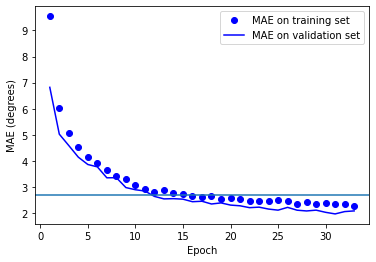

31/31 [==============================] - 0s 8ms/step - loss: 8.7492 - mae: 2.2470
Test MAE = 2.25 degrees


In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm3, baseline)
print('Test MAE = %.2f degrees' % model_lstm3.evaluate(test_dataset)[1])

Validation MAE = 2.24 degrees
Test MAE = 2.25 degrees

In [5]:
def plot_hist_classif(hist):
  n_ = len(hist.history['accuracy'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Accuracy")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()


In [6]:
max_features = 15000  # only consider the top 15k words
maxlen = 500  # first 500 words of each review
batch_size = 32

print('Loading data...')
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_test), 'test sequences', x_test.shape)

Loading data...
25000 train sequences (25000,)
25000 test sequences (25000,)


In [ ]:
# How balanced is this dataset?
print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

0.5
0.5


In [7]:
# Merge the two datasets and divide: 60% for training, 20% validation, 20% test
x_, y_ = np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))
print(x_.shape, y_.shape)
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.4, random_state=10)  # 60/40 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)  # 50/50 split
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_val), 'validation sequences', x_val.shape)
print(len(x_test), 'test sequences', x_test.shape)

(50000,) (50000,)
30000 train sequences (30000,)
10000 validation sequences (10000,)
10000 test sequences (10000,)


In [11]:
x_train[0][:10]  # numbers!!

[1, 11531, 186, 8, 28, 6, 6482, 7, 269, 4042]

In [8]:
# We can explore what one of the reviews looks like at this point.

# Retrieve the word index file that maps words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words (which is what we have)
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

"the lilly horror in one is fatale br looks meaningless in bronson be showing as you debut film ample to and ingredients zombi ample they for series and thought she's all manipulate and believing in j show look early last quote desire tight interesting that's kind out is far shelter but of frame br and"

In [9]:
# Let's ensure all sequences have the same length through padding
# - shorter reviews are padded with 0's
# - longer reviews are cut
print('Pad sequences')
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (30000, 500)
x_val shape: (10000, 500)
x_test shape: (10000, 500)


In [ ]:
# Basic feedforward model
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 dense (Dense)               (None, 500, 64)           8256      
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 500, 64)           4160      
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [ ]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
600/600 [==============================] - 11s 12ms/step - loss: 0.5416 - accuracy: 0.6834 - val_loss: 0.2962 - val_accuracy: 0.8792
Epoch 2/20
600/600 [==============================] - 7s 12ms/step - loss: 0.2710 - accuracy: 0.8897 - val_loss: 0.3024 - val_accuracy: 0.8806
Epoch 3/20
600/600 [==============================] - 7s 12ms/step - loss: 0.2116 - accuracy: 0.9162 - val_loss: 0.2853 - val_accuracy: 0.8878
Epoch 4/20
600/600 [==============================] - 7s 12ms/step - loss: 0.1802 - accuracy: 0.9322 - val_loss: 0.2871 - val_accuracy: 0.8895
Epoch 5/20
600/600 [==============================] - 7s 12ms/step - loss: 0.1568 - accuracy: 0.9423 - val_loss: 0.3003 - val_accuracy: 0.8881
Epoch 6/20
600/600 [==============================] - 7s 11ms/step - loss: 0.1467 - accuracy: 0.9472 - val_loss: 0.4701 - val_accuracy: 0.8531
Epoch 7/20
600/600 [==============================] - 7s 12ms/step - loss: 0.1305 - accuracy: 0.9514 - val_loss: 0.3235 - val_accuracy: 0.886

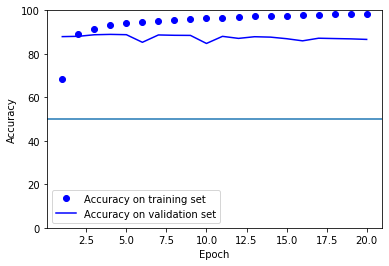

200/200 [==============================] - 1s 3ms/step - loss: 0.6329 - accuracy: 0.8677
Test Accuracy = 0.87


In [ ]:
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])  # overfitting!

In [ ]:
# Let's try an RNN
model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          960000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,058,945
Trainable params: 1,058,945
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
938/938 [==============================] - 31s 25ms/step - loss: 0.3973 - accuracy: 0.8282 - val_loss: 0.3026 - val_accuracy: 0.8765
Epoch 2/20
938/938 [==============================] - 23s 25ms/step - loss: 0.2640 - accuracy: 0.8998 - val_loss: 0.3140 - val_accuracy: 0.8732
Epoch 3/20
938/938 [==============================] - 24s 26ms/step - loss: 0.2243 - accuracy: 0.9179 - val_loss: 0.2614 - val_accuracy: 0.8952
Epoch 4/20
938/938 [==============================] - 28s 30ms/step - loss: 0.1918 - accuracy: 0.9313 - val_loss: 0.2517 - val_accuracy: 0.9044
Epoch 5/20
938/938 [==============================] - 24s 25ms/step - loss: 0.1660 - accuracy: 0.9411 - val_loss: 0.2765 - val_accuracy: 0.9034
Epoch 6/20
938/938 [==============================] - 23s 25ms/step - loss: 0.1487 - accuracy: 0.9492 - val_loss: 0.2503 - val_accuracy: 0.9076
Epoch 7/20
938/938 [==============================] - 23s 24ms/step - loss: 0.1266 - accuracy: 0.9573 - val_loss: 0.5141 - val_accuracy:

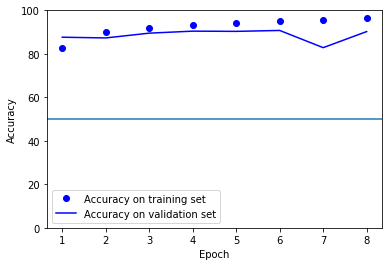

313/313 [==============================] - 4s 11ms/step - loss: 0.2758 - accuracy: 0.9023
Test Accuracy = 0.90


In [ ]:
# This model will take a long time to train, so we add an early stopping criterion
# N.B: It's actually much faster to train WITHOUT A GPU!!
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])
# Note that we're still overfitting, but this is just an example of use

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 500, 64)           960000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 500, 64)          24832     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 20)               6000      
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 990,853
Trainable params: 990,853
Non-tr

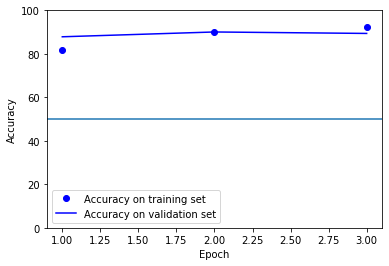

313/313 [==============================] - 55s 170ms/step - loss: 0.2667 - accuracy: 0.8978
Test Accuracy = 0.90


In [16]:
n_ = 10  # number of epochs. You can edit this

model = models.Sequential()
model.add(layers.Embedding(max_features, 64, input_length=maxlen))
model.add(Bidirectional(LSTM(32, return_sequences=True) ))
model.add(Bidirectional(LSTM(10)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation="sigmoid"))

# I DON'T RECOMMEND THAT YOU CHANGE CODE AFTER THIS POINT
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())

# This model will take a long time to train, so we add an early stopping criterion
# I've also added a ModelCheckpoint that will save the best model according to val_accuracy regardless of whether we continue training
callbacks = [EarlyStopping(monitor='val_accuracy', patience=1),
             ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", mode='max')]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)
plot_hist_classif(history)
model = keras.models.load_model("model.keras")
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])

In [ ]:
print(model.count_params())

196449


In [17]:
keras.models.save_model(model, "Model1.h5",save_format='h5')

In [18]:
if model.count_params() > 1000000:
    print("Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.")

if history.history["val_accuracy"][-1] > 0.8:
    print("Your model is accurate enough!")

else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")
# Save the model into a local folder
keras.models.save_model(model, "Model.h5",save_format='h5')
print('Model saved! You can now upload it to the lab quiz.')

Your model is accurate enough!
Model saved! You can now upload it to the lab quiz.
